# full dataset

In [52]:
os.listdir('/media/miplab-nas2/Data3/Ilaria/test_HRF')

['C_sub-01', 'HCP_sub', 'L_sub_AT', '.DS_Store']

In [7]:
PATH = '/media/RCPNAS/Data3/Ilaria/TS_data/cervicaltask_noBP/Parc56/'
import os
import numpy as np
subjects_name = os.listdir(PATH + 'ses2/')
print(subjects_name)
spinal_data = np.concatenate([np.load(PATH + ses + name).T for ses in ['ses1/', 'ses2/'] for name in os.listdir(PATH + ses)])

['sub-4.npy', 'sub-10.npy', 'sub-14.npy', 'sub-9.npy', 'sub-3.npy', 'sub-8.npy', 'sub-12.npy', 'sub-15.npy', 'sub-11.npy', 'sub-1.npy', 'sub-2.npy', 'sub-13.npy', 'sub-7.npy', 'sub-6.npy', 'sub-5.npy']


In [59]:
data = np.load("data/fmri/spinal_data.npy")
reshaped = data.reshape(30, 125, -1)
final = np.diff(reshaped, axis=1).reshape(-1, 56)
final.shape

(3720, 56)

In [60]:
np.save("data/fmri/first_order_spinal_data.npy", final)

In [1]:
import numpy as np
data = np.load("data/fmri/spinal_data.npy")
data.shape

(3750, 56)

In [4]:
import numpy as np
from utils import z_score
from lib.clustering.glmm import GLMM

ACTIVITY = np.load("data/resources/activity.npy")
X = z_score(np.load("data/fmri/spinal_data.npy")) # (N samples, M dimensions)

print("Loaded X", X.shape, "mean, std:", X.mean(), X.std())
duration = X.shape[0]//30

laplacians_init_ = None
Y = X.reshape(30, duration, 56).mean(axis=0)

laplacians_ = np.stack([np.corrcoef(Y[ACTIVITY==label].T) for label in [0, 1]]) # shape [K, D, D]
means_ = np.array([Y[ACTIVITY==label].mean(axis=0) for label in [0, 1]]) # shape [K, D]
resp_ = np.array([(np.tile(ACTIVITY, 30) == label).astype(int) for label in [0, 1]]) # shape [K, N]

laplacians_init_ = (resp_.mean(axis=1), means_,laplacians_, resp_)
print('init laplacians shape:', laplacians_.shape)

model = GLMM(n_components=2, avg_degree=44, delta=0.25, random_state=3, init_params="kmeans", laplacian_init=laplacians_init_)

print(laplacians_.shape)
print("GLMM...")
prediction = model.fit_predict(X)

Loaded X (3750, 56) mean, std: 6.936250515753359e-19 0.9999998448200188
init laplacians shape: (2, 56, 56)
(2, 56, 56)
GLMM...


In [7]:
from scipy import stats
print('rest state correl', [stats.pearsonr(laplacians_[0].flatten(), model.laplacians_[i].flatten()) for i in [0, 1]])
print('active state correl', [stats.pearsonr(laplacians_[1].flatten(), model.laplacians_[i].flatten()) for i in [0, 1]])

rest state correl [PearsonRResult(statistic=0.685276145166086, pvalue=0.0), PearsonRResult(statistic=0.6836048399591996, pvalue=0.0)]
active state correl [PearsonRResult(statistic=0.6404858699704675, pvalue=0.0), PearsonRResult(statistic=0.6314723317354862, pvalue=0.0)]


In [12]:

from scipy.stats import ttest_ind

print('rest mean diff', np.array([np.abs(means_[0] - model.means_[i]) for i in [0, 1]]).mean(axis=1), [ttest_ind(means_[0], model.means_[i]) for i in [0, 1]])
print('active mean diff', np.array([np.abs(means_[1] - model.means_[i]) for i in [0, 1]]).mean(axis=1), [ttest_ind(means_[1], model.means_[i]) for i in [0, 1]])

rest mean diff [0.03260051 0.04276337] [TtestResult(statistic=-2.9075427986805282, pvalue=0.004407063187580819, df=110.0), TtestResult(statistic=-3.994199264186604, pvalue=0.00011759413555238098, df=110.0)]
active mean diff [0.0485581  0.03335739] [TtestResult(statistic=4.309045793356085, pvalue=3.5825831809172516e-05, df=110.0), TtestResult(statistic=3.862994328811017, pvalue=0.0001896589443213006, df=110.0)]


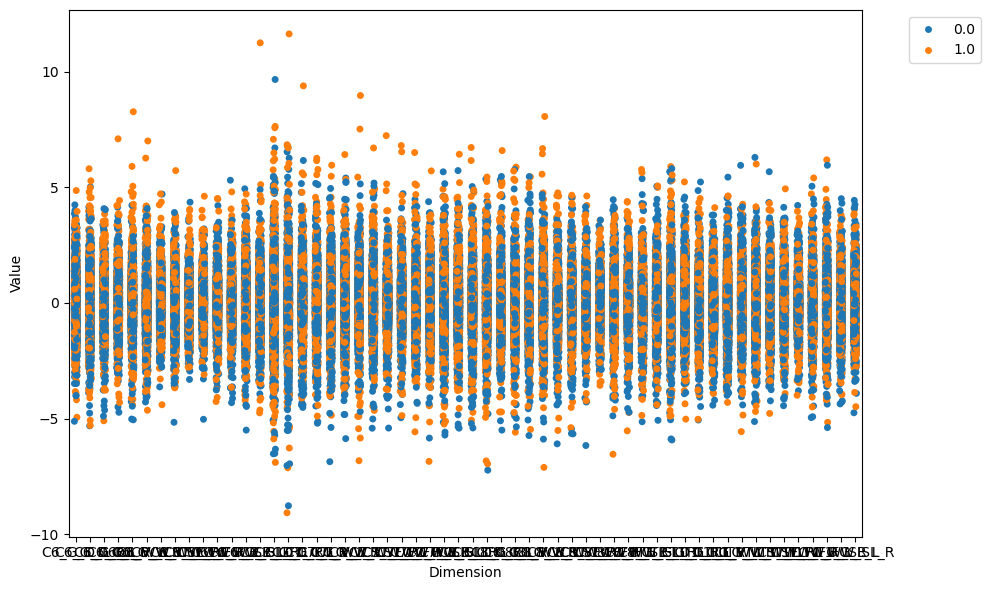

,4,21,5,18,11,9,33,8,52,22,...,36,49,0,48,51,43,15,23,29,53
Dimension,C6_G_V_L,C7_W_CST_R,C6_G_V_R,C7_G_V_L,C6_W_FG_R,C6_W_FC_R,C8_G_V_R,C6_W_FC_L,T1_W_FG_L,C7_W_FC_L,...,C8_W_FC_L,T1_W_CST_R,C6_G_D_L,T1_W_CST_L,T1_W_FC_R,T1_G_D_R,C7_G_D_R,C7_W_FC_R,C8_G_D_R,T1_W_FG_R
p-value,0.000067,0.000728,0.001135,0.00208,0.002427,0.003728,0.003824,0.004275,0.004601,0.004621,...,0.617096,0.622574,0.639839,0.646784,0.710995,0.741935,0.801164,0.94018,0.98395,0.995454


In [33]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import z_score
data = z_score(np.load("data/fmri/spinal_data.npy"))
ATLAS = pd.read_csv("data/resources/pam50_atlas.csv")["regions_of_interest"].values
ACTIVITY = np.load("data/resources/activity.npy")

df = pd.DataFrame(data, columns=ATLAS)
df['Label'] = np.tile(ACTIVITY, 30)
df_melt = df.melt(id_vars='Label', var_name='Dimension', value_name='Value')

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_melt, x='Dimension', y='Value', hue='Label', jitter=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

p_values = [stats.f_oneway(*(data[np.tile(ACTIVITY, 30) == lbl, i] for lbl in np.unique(ACTIVITY)))[1] for i in range(len(ATLAS))]
display(pd.DataFrame({'Dimension': ATLAS, 'p-value': p_values}).sort_values('p-value').T)



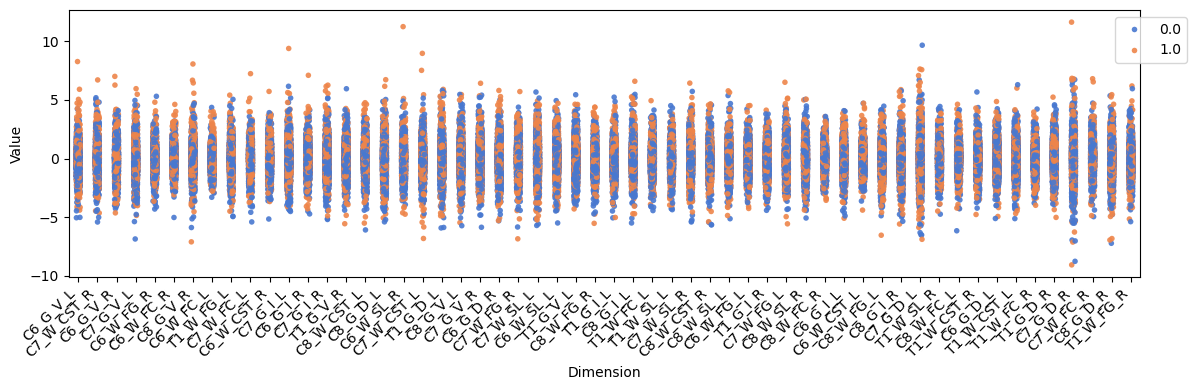

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
Dimension,C6_G_V_L,C7_W_CST_R,C6_G_V_R,C7_G_V_L,C6_W_FG_R,C6_W_FC_R,C8_G_V_R,C6_W_FC_L,T1_W_FG_L,C7_W_FC_L,...,C8_W_FC_L,T1_W_CST_R,C6_G_D_L,T1_W_CST_L,T1_W_FC_R,T1_G_D_R,C7_G_D_R,C7_W_FC_R,C8_G_D_R,T1_W_FG_R
p-value,0.000067,0.000728,0.001135,0.00208,0.002427,0.003728,0.003824,0.004275,0.004601,0.004621,...,0.617096,0.622574,0.639839,0.646784,0.710995,0.741935,0.801164,0.94018,0.98395,0.995454


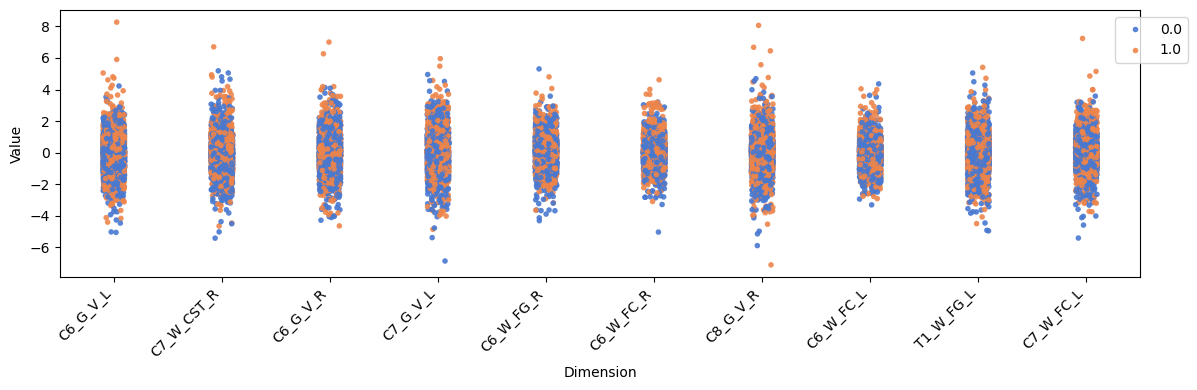

,0,1,2,3,4,5,6,7,8,9
Dimension,C6_G_V_L,C7_W_CST_R,C6_G_V_R,C7_G_V_L,C6_W_FG_R,C6_W_FC_R,C8_G_V_R,C6_W_FC_L,T1_W_FG_L,C7_W_FC_L
p-value,0.000067,0.000728,0.001135,0.00208,0.002427,0.003728,0.003824,0.004275,0.004601,0.004621


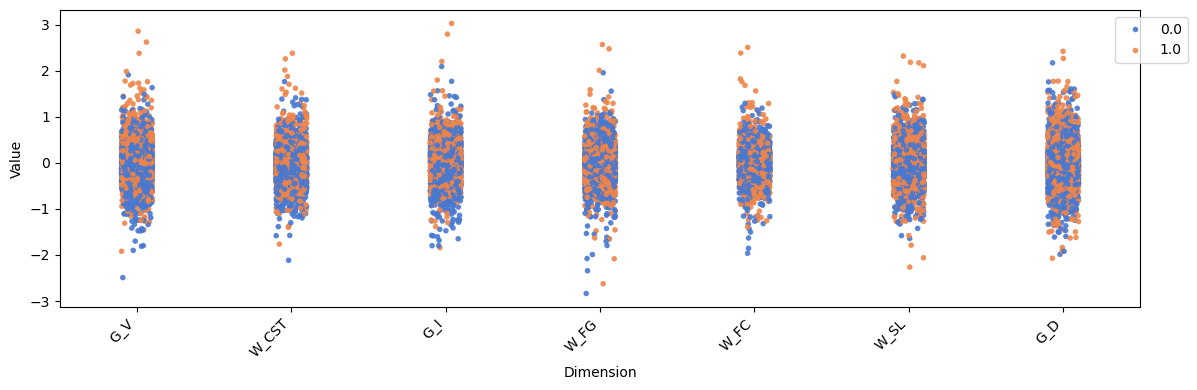

,0,1,2,3,4,5,6
Dimension,G_V,W_CST,G_I,W_FG,W_FC,W_SL,G_D
p-value,0.0,0.000052,0.000102,0.000281,0.010106,0.011637,0.040984


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_and_analyze(X, labels, dimension_names, group_levels=False, k=None):
    df = pd.DataFrame(X, columns=dimension_names)
    df['Label'] = labels
    if group_levels:
        levels = pd.DataFrame([name.split('_') for name in dimension_names], columns=['level', 'matter', 'parcel', 'side'])
        levels['Dimension'] = dimension_names
        grouped = levels.groupby(['matter', 'parcel'])['Dimension'].apply(list)

        for (matter, parcel), dims in grouped.items():
            group_name = f"{matter}_{parcel}"
            df[group_name] = df[dims].mean(axis=1)
        dimension_names = grouped.index.map(lambda x: f"{x[0]}_{x[1]}").tolist()
        df = df[['Label'] + dimension_names]
    p_values = [stats.f_oneway(*(df[df['Label'] == lbl][dim] for lbl in df['Label'].unique()))[1] for dim in dimension_names]
    p_values_df = pd.DataFrame({'Dimension': dimension_names, 'p-value': p_values}).sort_values('p-value')
    if k:
        top_dims = p_values_df.nsmallest(k, 'p-value')['Dimension'].tolist()
        df = df[['Label'] + top_dims]
        dimension_names = top_dims
    df_melt = df.melt(id_vars='Label', var_name='Dimension', value_name='Value')
    plt.figure(figsize=(12, 4))
    sns.stripplot(data=df_melt, x='Dimension', y='Value', hue='Label', jitter=0.1, size=4, alpha=0.9, palette="muted")
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    display(p_values_df[:k].reset_index(drop=True).T)

# Example usage:
plot_and_analyze(data, np.tile(ACTIVITY, 30), ATLAS, group_levels=False, k=56)
plot_and_analyze(data, np.tile(ACTIVITY, 30), ATLAS, group_levels=False, k=10)
plot_and_analyze(data, np.tile(ACTIVITY, 30), ATLAS, group_levels=True, k=10)


In [35]:
X = data
labels = np.tile(ACTIVITY, 30)
dimension_names =  ATLAS
df = pd.DataFrame(X, columns=dimension_names)
df['Label'] = labels
levels = pd.DataFrame([name.split('_') for name in dimension_names], columns=['level', 'matter', 'parcel', 'side'])
levels['Dimension'] = dimension_names
grouped = levels.groupby(['matter', 'parcel'])['Dimension'].apply(list)

for (matter, parcel), dims in grouped.items():
    group_name = f"{matter}_{parcel}"
    df[group_name] = df[dims].mean(axis=1)
dimension_names = grouped.index.map(lambda x: f"{x[0]}_{x[1]}").tolist()
df = df[['Label'] + dimension_names]

df.sample()

,Label,G_D,G_I,G_V,W_CST,W_FC,W_FG,W_SL
3189,0.0,-0.268964,-0.034852,-0.079757,0.210436,0.103784,0.005698,0.14112


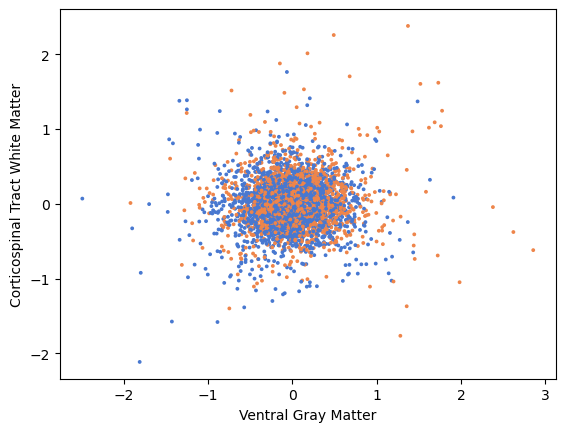

,G_D,G_I,G_V,W_CST,W_FC,W_FG,W_SL
Label,,,,,,,
0.0,-0.012907,-0.021050,-0.038680,-0.022211,-0.012854,-0.020219,-0.015662
1.0,0.017043,0.028384,0.049763,0.025066,0.014079,0.026162,0.016418


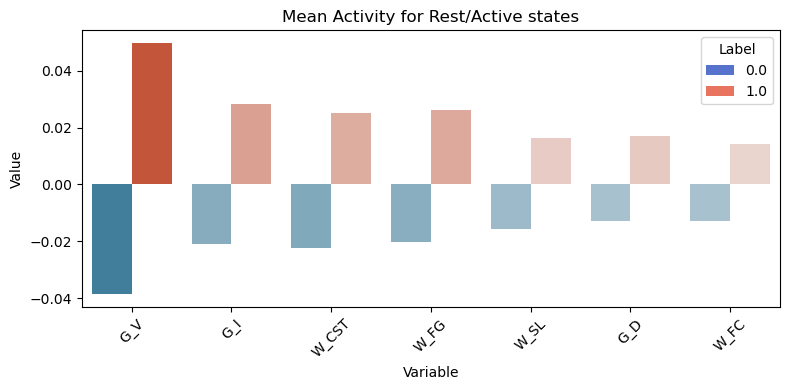

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = np.array(sns.color_palette('muted', 10))
plt.scatter(df['G_V'], df['W_CST'], c = palette[df['Label'].values.astype(int)], s=3)
plt.xlabel('Ventral Gray Matter')
plt.ylabel('Corticospinal Tract White Matter')
plt.show()

ds= df.groupby('Label').mean()
display(ds)

abs_diff = ds.diff().abs().iloc[1]
sorted_columns = abs_diff.sort_values(ascending=False).index
df_long = ds[sorted_columns].stack().reset_index()
df_long.columns = ["Label", "Variable", "Value"]

palette = sns.diverging_palette(230, 20, as_cmap=True)
norm = plt.Normalize(df_long["Value"].min(), df_long["Value"].max())
colors = palette(norm(df_long["Value"]))

plt.figure(figsize=(8, 4))
bars = sns.barplot(
    data=df_long,
    x="Variable",
    y="Value",
    hue="Label",
    palette=['royalblue', 'tomato'],
    dodge=True,
    order=sorted_columns,
)
for bar, color in zip(bars.patches, colors):
    bar.set_facecolor(color)
plt.xticks(rotation=45)
plt.title("Mean Activity for Rest/Active states")
plt.tight_layout()
plt.show()

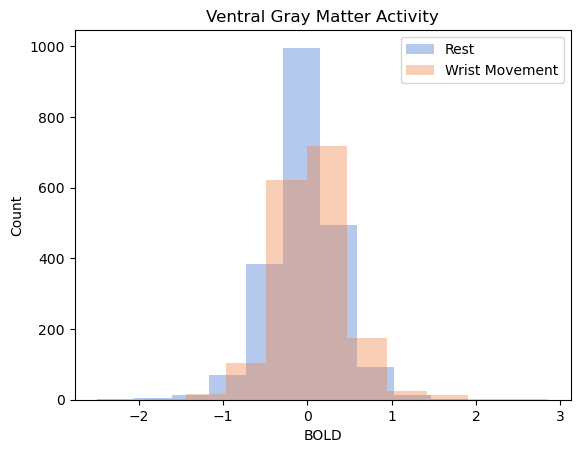

In [47]:
for idx, label in enumerate(df['Label'].unique()):
    plt.hist(df.query(f'Label == {label}')['G_V'], alpha=0.4, label = ['Rest' , 'Wrist Movement'][int(label)], color=sns.color_palette('muted', 2)[idx])
plt.legend()
plt.title('Ventral Gray Matter Activity')
plt.ylabel('Count')
plt.xlabel('BOLD')
plt.show()

## save first level

In [ ]:
import pandas as pd
import numpy as np
labels = pd.read_csv("database/pam50_atlas.csv"); labels
spinal_data = np.load("database/datasets/spinal_data.npy")
np.save("database/datasets/C6_spinal_data.npy", spinal_data[:, :14])

In [9]:
labels.T
spinal_data = np.load("database/datasets/C6_spinal_data.npy")
np.save("database/datasets/C6_GM_spinal_data.npy", spinal_data[:, :6])

# paradigm

In [1]:
import numpy as np
import pandas as pd

timings = pd.read_csv("database/activity_paradigm_Z3mm.csv")

In [4]:
activity = np.zeros(125)
for idx, row in timings.iterrows():
    start, end = round(row["Times"]), round(row["Times"] + row["Durations"])
    activity[start:end] = 1
np.save("activity.npy", activity)

# init laplacians, frobenious norm

In [7]:
import matplotlib.pyplot as plt
import numpy as np


#spinal_data = np.load("data/fmri/spinal_data.npy").reshape(-1, 125, 56).mean(axis=0)
#fc = np.corrcoef(spinal_data.T)
#fc = np.where(fc < 0, 0, fc)
#np.save("data/fc.npy", fc)

(56, 56) (69, 56)


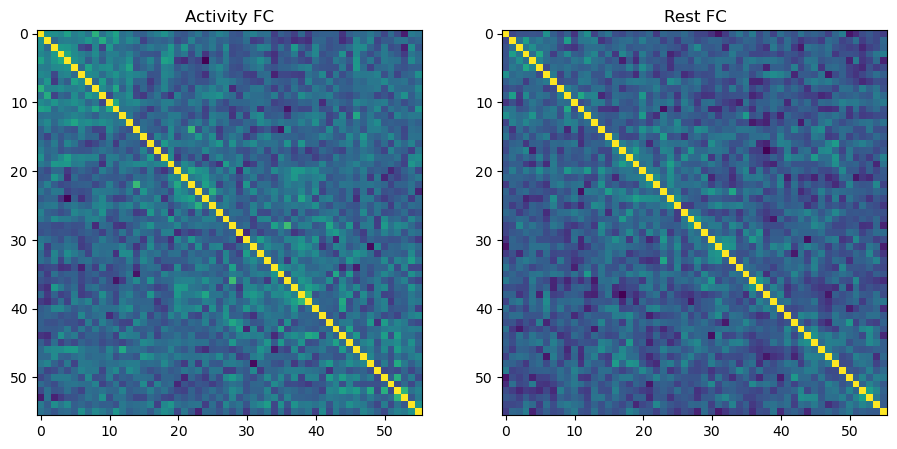

In [8]:
spinal_data = np.load("data/fmri/spinal_data.npy").reshape(-1, 125, 56).mean(axis=0)
activity = np.load("data/resources/activity.npy")

activity_data = spinal_data[activity == 1]
rest_data = spinal_data[activity == 0]
print(activity_data.shape, rest_data.shape)

fig, ax = plt.subplots(1, 2, figsize = (11 , 5))
ax[0].imshow(np.corrcoef(activity_data.T))
ax[0].set_title('Activity FC')
ax[1].imshow(np.corrcoef(rest_data.T))
ax[1].set_title('Rest FC')
plt.show()

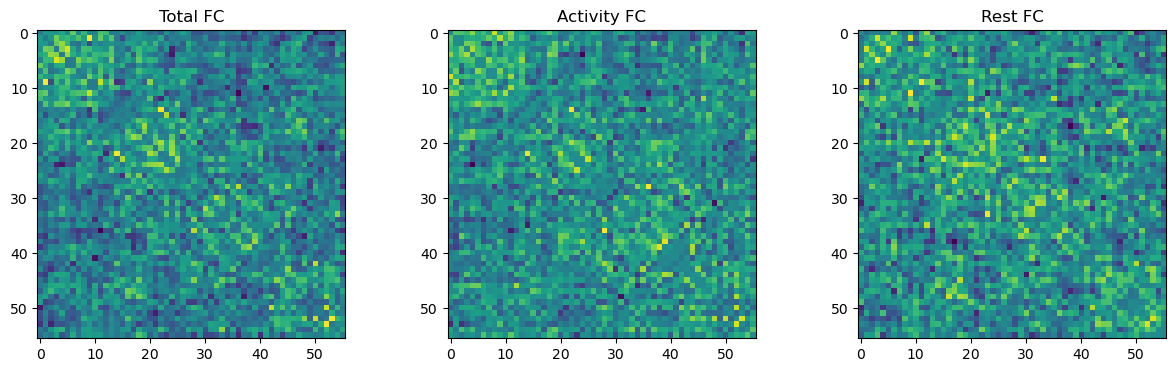

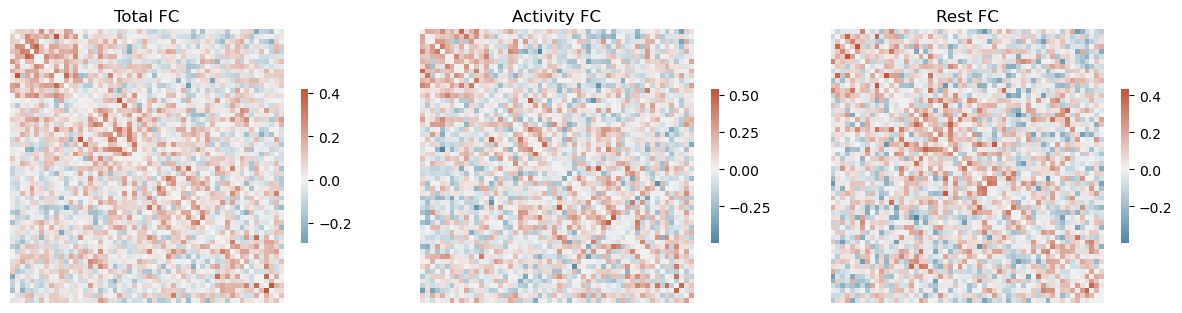

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15 , 4))
ax[1].imshow(np.corrcoef(activity_data.T) - np.diag(np.diag(np.corrcoef(activity_data.T))))
ax[1].set_title('Activity FC')
ax[2].imshow(np.corrcoef(rest_data.T) - np.diag(np.diag(np.corrcoef(rest_data.T))))
ax[2].set_title('Rest FC')
ax[0].imshow(np.corrcoef(spinal_data.T) - np.diag(np.diag(np.corrcoef(spinal_data.T))))
ax[0].set_title('Total FC')
plt.show()
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize = (15 , 4))
sns.heatmap(np.corrcoef(activity_data.T) - np.diag(np.diag(np.corrcoef(activity_data.T))),
             cmap=sns.diverging_palette(230, 20, as_cmap=True), square=True, center=0, cbar_kws={"shrink": .5}, ax=ax[1])

ax[1].set_title('Activity FC')
sns.heatmap(np.corrcoef(rest_data.T) - np.diag(np.diag(np.corrcoef(rest_data.T))),
             cmap=sns.diverging_palette(230, 20, as_cmap=True), square=True, center=0, cbar_kws={"shrink": .5}, ax=ax[2])
ax[2].set_title('Rest FC')
sns.heatmap(np.corrcoef(spinal_data.T) - np.diag(np.diag(np.corrcoef(spinal_data.T))),
             cmap=sns.diverging_palette(230, 20, as_cmap=True), square=True, center=0, cbar_kws={"shrink": .5}, ax=ax[0])
ax[0].set_title('Total FC')
ax[0].set_xticks(ticks=[], labels=[])
ax[0].set_yticks(ticks=[], labels=[])
ax[1].set_xticks(ticks=[], labels=[])
ax[1].set_yticks(ticks=[], labels=[])
ax[2].set_xticks(ticks=[], labels=[])
ax[2].set_yticks(ticks=[], labels=[])
plt.show()

In [ ]:
from scipy.stats import chi2

def jennrich_test(cor_matrix1, cor_matrix2, n1, n2):
    k = cor_matrix1.shape[0]
    diff_matrix = cor_matrix1 - cor_matrix2
    statistic = (n1 + n2 - 2) * np.sum(diff_matrix**2)
    p_value = 1 - chi2.cdf(statistic, k * (k - 1) / 2)
    return statistic, p_value

jennrich_test(np.corrcoef(activity_data.T), np.corrcoef(rest_data.T), 56, 69)

(12653.468250920276, 0.0)

In [24]:
diff = np.corrcoef(activity_data.T) - np.corrcoef(rest_data.T)
np.linalg.norm(diff, ord='fro'), np.linalg.norm(np.ones((56,56))- np.zeros((56,56)), ord='fro'), np.linalg.norm(np.random.randn(56,56)- np.random.randn(56,56), ord='fro')


(10.14266856489149, 56.0, 78.12318891613917)

In [ ]:
from scipy.stats import f

def hotellings_t2(x1, x2):
    n1, p = x1.shape
    n2 = x2.shape[0]
    diff = x1.mean(axis=0) - x2.mean(axis=0)
    s_pool = ((n1 - 1)*np.cov(x1, rowvar=False) + (n2 - 1)*np.cov(x2, rowvar=False))/(n1 + n2 - 2)
    t2 = n1*n2/(n1 + n2) * diff @ np.linalg.inv(s_pool) @ diff
    f_stat = (n1 + n2 - p - 1)*t2/((n1 + n2 - 2)*p)
    p_value = 1 - f.cdf(f_stat, p, n1 + n2 - p - 1)
    return t2, p_value
hotellings_t2(activity_data, rest_data)

(242.3222641573006, 0.0003284122607120077)

In [6]:
#print('activity data', activity_data.mean(axis=0), rest_data.mean(axis=1))
from sklearn.metrics import silhouette_score
silhouette_score(spinal_data, activity)

0.02000540359650533

# 2 questions: 
### can we find these unsupervised?
### are the graphs better, more structurally related?


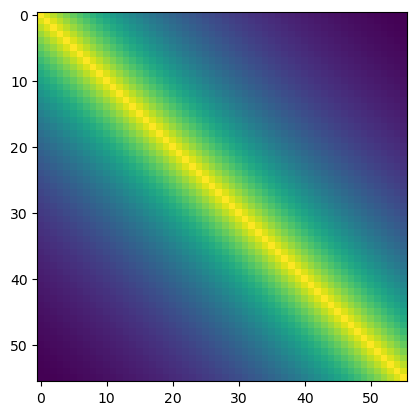

In [5]:
import numpy as np
import matplotlib.pyplot as plt
n = 1
d = 56
#sample_uniform = np.random.randn(n,d)
#covariance = sample_uniform.T @ sample_uniform

sigma, beta = 1, 5e-2
covariance = sigma**2 * np.exp(-beta*np.abs(np.arange(d)[:, None] - np.arange(d)))
#covariance = np.linalg.pinv(covariance)
plt.imshow(covariance)
plt.show()

In [38]:
def generate_clusters(n = 100, d = 56, radius=1, covariance=None, sigma=1):
    centroid = np.random.normal(size=d); centroid /= np.linalg.norm(centroid)/radius
    if covariance is None: covariance = sigma**2 * np.exp(-(5e-2)*np.abs(np.arange(d)[:, None] - np.arange(d)))

    X = np.concatenate([ 
        np.random.multivariate_normal(np.zeros(d), covariance, n//2),
        np.random.multivariate_normal(centroid, covariance, n//2),
    ])
    labels = np.concatenate([np.zeros(n//2), np.ones(n//2)])
    
    indexes = np.array([np.arange(idx, idx +  n//10) for idx in range(0, n, n//10)])
    np.random.shuffle(indexes)
    indexes = indexes.flatten()

    print("Data shape:", X.shape)
    return X[indexes], labels[indexes]
X, labels = generate_clusters(n=500, d=56, radius=2, sigma=1)



Data shape: (500, 56)


Activity Score: [1. 0.]
Silhouette Score: 0.02401626851216303


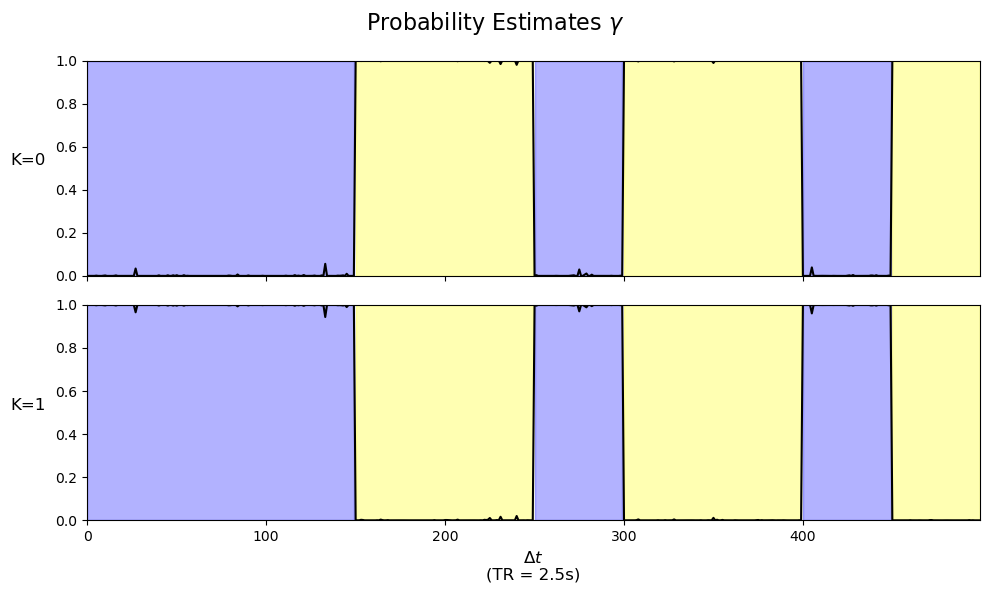

In [39]:
from lib.clustering.glmm import GLMM
from utils import cluster_score, plot_probability_estimates
mixture = GLMM(2, avg_degree=10, delta=2)

prediction = mixture.fit_predict(X)
gamma = mixture.predict_proba(X) 
f1, silhouette = cluster_score(gamma, labels, X, prediction)
print("Activity Score:", f1)
print("Silhouette Score:", silhouette)

plot_probability_estimates(gamma, labels)


# Check gridsearch results

In [48]:
import pandas as pd
import numpy as np
results = pd.read_csv('data/runs/glmm-gridsearch20241207-1459/results.csv', index_col=0); results.sample()
for col in ['F1', 'Weights']:
    results[col] = results[col].str.strip('[]').str.split().apply(lambda x: list(map(float, x)))
results = results.assign(best_F1 = results['F1'].apply(lambda f: max(f)),
                         best_cluster = results['F1'].apply(lambda f: np.argmax(f)))

results['balanced'] = results['Weights'].apply(lambda w: np.abs( np.array(w) - 1/len(w) ).max())

In [ ]:
display(results.sort_values('best_F1', ascending=False).head(10),
        results.sort_values('SS', ascending=False).head(10),
        results.sort_values('balanced', ascending=True).head(10),)

,K,Degree,Delta,F1,SS,Weights,best_F1,best_cluster,balanced
1922,6,44,0.2500,"[0.525, 0.65, 0.34, 0.478, 0.345, 0.454]",-0.014036,"[0.21409681, 0.1928519, 0.04602974, 0.2421136,...",0.650,1,0.120637
1874,6,38,0.2500,"[0.533, 0.643, 0.357, 0.496, 0.407, 0.475]",-0.021509,"[0.04385414, 0.19084861, 0.04917457, 0.3293382...",0.643,1,0.162672
1898,6,41,0.2500,"[0.531, 0.639, 0.364, 0.421, 0.389, 0.442]",0.002942,"[0.05634533, 0.20890762, 0.05588125, 0.3452147...",0.639,1,0.178548
1600,6,4,0.0625,"[0.639, 0.365, 0.343, 0.46, 0.404, 0.504]",0.233125,"[0.28946291, 0.06237079, 0.1416655, 0.06482877...",0.639,0,0.122796
1906,6,42,0.2500,"[0.517, 0.631, 0.36, 0.456, 0.336, 0.41]",-0.020156,"[0.15550434, 0.19492137, 0.0504034, 0.26075548...",0.631,1,0.116263
1890,6,40,0.2500,"[0.504, 0.63, 0.349, 0.47, 0.37, 0.446]",-0.021220,"[0.039452, 0.18672733, 0.07045146, 0.32035975,...",0.630,1,0.153693
1268,5,12,1.0000,"[0.446, 0.626, 0.426, 0.342, 0.424]",-0.037873,"[0.17708442, 0.20863959, 0.2504771, 0.12021381...",0.626,1,0.079786
1828,6,32,1.0000,"[0.235, 0.359, 0.349, 0.624, 0.164, 0.283]",-0.167038,"[0.00343401, 0.00952112, 0.09044659, 0.8459773...",0.624,3,0.679311
2045,7,9,2.0000,"[0.458, 0.486, 0.411, 0.396, 0.393, 0.623, 0.557]",-0.084754,"[0.06725615, 0.04730185, 0.12842972, 0.0468323...",0.623,5,0.284423
1779,6,26,0.5000,"[0.446, 0.622, 0.387, 0.5, 0.479, 0.33]",-0.035324,"[0.29168885, 0.11305859, 0.03797785, 0.1228156...",0.622,1,0.128689


,K,Degree,Delta,F1,SS,Weights,best_F1,best_cluster,balanced
246,2,34,4.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
239,2,33,8.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
255,2,35,8.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
230,2,32,4.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
231,2,32,8.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
261,2,36,2.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
262,2,36,4.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
222,2,31,4.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
238,2,33,4.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667
287,2,39,8.0,"[0.164, 0.58]",0.551534,"[0.00133333, 0.99866667]",0.58,1,0.498667


,K,Degree,Delta,F1,SS,Weights,best_F1,best_cluster,balanced
192,2,28,0.0625,"[0.478, 0.468]",0.002118,"[0.49992491, 0.50007509]",0.478,0,0.000075
298,2,41,0.2500,"[0.47, 0.475]",0.005029,"[0.4997875, 0.5002125]",0.475,1,0.000213
96,2,16,0.0625,"[0.456, 0.488]",0.003944,"[0.4996086, 0.5003914]",0.488,1,0.000391
200,2,29,0.0625,"[0.491, 0.455]",0.016140,"[0.50189271, 0.49810729]",0.491,0,0.001893
208,2,30,0.0625,"[0.496, 0.452]",0.015825,"[0.5022875, 0.4977125]",0.496,0,0.002287
124,2,19,1.0000,"[0.467, 0.479]",0.002161,"[0.49761029, 0.50238971]",0.479,1,0.002390
219,2,31,0.5000,"[0.504, 0.441]",0.008697,"[0.5024352, 0.4975648]",0.504,0,0.002435
128,2,20,0.0625,"[0.397, 0.545]",0.084709,"[0.49675174, 0.50324826]",0.545,1,0.003248
227,2,32,0.5000,"[0.5, 0.446]",0.017170,"[0.49630465, 0.50369535]",0.500,0,0.003695
8,2,5,0.0625,"[0.454, 0.492]",0.059498,"[0.50459461, 0.49540539]",0.492,1,0.004595


In [56]:
results[['K', 'Degree', 'Delta', 'best_F1', 'SS', 'balanced']]

,K,Degree,Delta,best_F1,SS,balanced
0,2,4,0.0625,0.612,0.230865,0.080120
1,2,4,0.1250,0.605,0.236875,0.015302
2,2,4,0.2500,0.504,0.057365,0.071807
3,2,4,0.5000,0.537,0.156646,0.297934
4,2,4,1.0000,0.508,0.045143,0.315669
...,...,...,...,...,...,...
2395,7,53,0.5000,0.606,0.019219,0.810765
2396,7,53,1.0000,0.519,0.149550,0.813749
2397,7,53,2.0000,0.485,0.305387,0.841410
2398,7,53,4.0000,0.508,0.056779,0.684367


In [58]:
import statsmodels.formula.api as smf
for metric in ['best_F1', 'SS', 'balanced']:
    model = smf.ols(f'{metric} ~ K + Degree + Delta', data=results[['K', 'Degree', 'Delta', 'best_F1', 'SS', 'balanced']]).fit()
    print(model.summary())
 

                            OLS Regression Results                            
Dep. Variable:                best_F1   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.89
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           7.41e-11
Time:                        00:02:53   Log-Likelihood:                 4046.7
No. Observations:                2400   AIC:                            -8085.
Df Residuals:                    2396   BIC:                            -8062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5306      0.003    164.315      0.0

In [71]:
data = []
for metric in ['best_F1', 'SS', 'balanced']:
    model = smf.ols(f'{metric} ~ K + Degree + Delta', data=results[['K', 'Degree', 'Delta', 'best_F1', 'SS', 'balanced']]).fit()
    row = {'Metric': metric, 'R2': model.rsquared}
    row.update({f'{var}_coef': coef for var, coef in model.params.items()})
    row.update({f'{var}_pval': pval for var, pval in model.pvalues.items()})
    data.append(row)

df = pd.DataFrame(data)
df = df.drop(['Intercept_coef', 'Intercept_pval', 'Metric'], axis=1)
df = df.T.map(lambda x: round(x, 3))
df.columns = ['best_F1', 'SS', 'balanced']
df

,best_F1,SS,balanced
R2,0.021,0.126,0.519
K_coef,-0.003,-0.021,0.031
Degree_coef,0.000,0.003,0.003
Delta_coef,0.001,0.021,0.078
K_pval,0.000,0.000,0.000
Degree_pval,0.000,0.000,0.000
Delta_pval,0.028,0.000,0.000


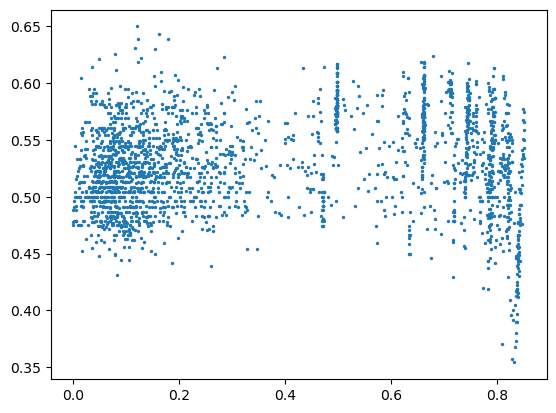

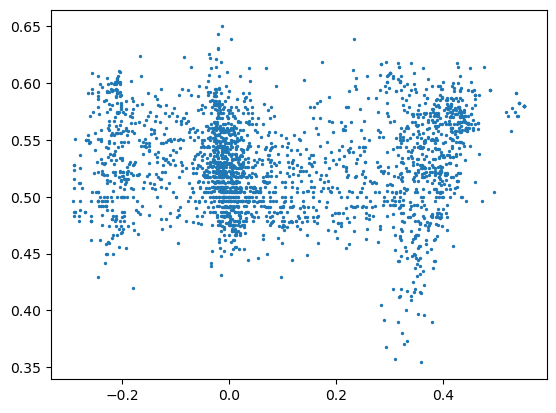

In [47]:
import matplotlib.pyplot as plt
plt.scatter(results['balanced'], results['best_F1'], s=2)
plt.show()
plt.scatter(results['SS'], results['best_F1'], s=2)

In [54]:
results=results.sort_values(['K','Degree','Delta'])
summary = pd.DataFrame()
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
for score in ['best_F1', 'SS',  'balanced']:
    H1,H2,H3 = map(np.unique,[results.K,results.Degree,results.Delta])
    S = mm.fit_transform(results[score].values.reshape(-1, 1)).flatten().reshape(len(H1),len(H2),len(H3))
    G = np.gradient(S,mm.fit_transform(H1.reshape(-1, 1)).flatten(),
                    mm.fit_transform(H2.reshape(-1, 1)).flatten(),
                    mm.fit_transform(H3.reshape(-1, 1)).flatten())
    results['dK'],results['dDegree'],results['dDelta']=[g.flatten() for g in G]
    summary[score] = results[['dK', 'dDegree', 'dDelta']].mean()

summary

,best_F1,SS,balanced
dK,-0.036503,-0.123812,0.198945
dDegree,-0.037378,0.204518,0.245711
dDelta,0.179236,-4.017261,1.509583


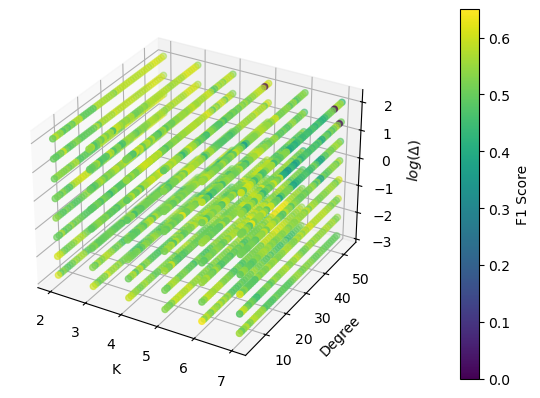

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

H1, H2, H3 = map(np.unique, [results.K, results.Degree, np.log(results.Delta)])
S = results.best_F1.values.reshape(len(H1), len(H2), len(H3))
X, Y, Z = np.meshgrid(H1, H2, H3, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=S.flatten(), cmap='viridis')
ax.set_xlabel('K')
ax.set_ylabel('Degree')
ax.set_zlabel('$log(\Delta) $')
fig.colorbar(p, ax=ax, label='F1 Score', anchor = (1, 0.1))
plt.show()


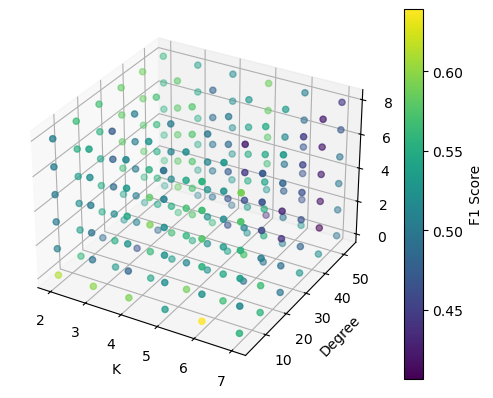

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator

results = results.sort_values(['K','Degree','Delta'])
H1,H2,H3 = map(np.unique, [results.K, results.Degree, results.Delta])
S = results.best_F1.values.reshape(len(H1), len(H2), len(H3))

mn = min(len(H1), len(H2), len(H3))
new_H1 = np.linspace(H1.min(), H1.max(), mn)
new_H2 = np.linspace(H2.min(), H2.max(), mn)
new_H3 = np.linspace(H3.min(), H3.max(), mn)

f = RegularGridInterpolator((H1,H2,H3), S)
Xn, Yn, Zn = np.meshgrid(new_H1, new_H2, new_H3, indexing='ij')
S_new = f((Xn, Yn, Zn))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(Xn.flatten(), Yn.flatten(), Zn.flatten(), c=S_new.flatten(), cmap='viridis')
ax.set_xlabel('K')
ax.set_ylabel('Degree')
ax.set_zlabel('Delta')
fig.colorbar(p, ax=ax, label='F1 Score')
plt.show()
